# Task 1

Here we will see how our nn and autograd works.

Also we will review some Catalyst's abstractions, implement callbacks and datasets.

Unfortunately, python is slow, and implementing dynamic computational graph in pure python for product-ready solution is not a good idea. But this task will help you to understand what's happening when you call `backward` method for variable or tensor. Also it will help you in learning Catalyst framework and will teach how you to write your code in more Catalyst-like way.

In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from nn import Linear, ReLU, CrossEntropyLoss, Module
from optim import SGD
from engine import Value, Tensor
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Defining toy dataset

To be more human-readable and easy to understand, we want to store every data in key-value format.

So, the dataset should yield dict, moreover we will store train/valid datasets in a dict.

In [2]:
class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, item):
        return {"features": X[item], "targets": y[item]}

    def __len__(self):
        return len(self.y)



X, y = make_moons(200, noise=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y)# Split data to Train and Valid
datasets = {"train": Dataset(X_train, y_train), "valid": Dataset(X_val, y_val)}

Take a look on a data.

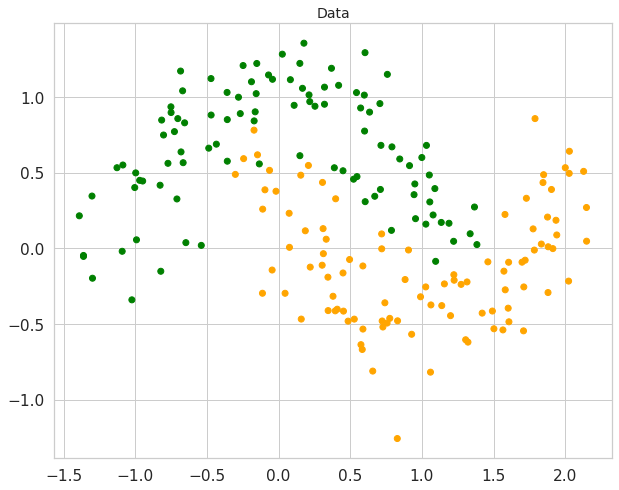

In [3]:
plt.figure(figsize=(10, 8))
plt.title("Data", fontsize=14)
colors = list(map(lambda x: "green" if x ==0 else "orange", y))
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.show()

### Model

Let's define our model in PyTorch-style. But don't forget to implement `parameters()` method.

In [4]:
class SimpleModel(Module):
    def __init__(self):
        self.layers = [
            Linear(2, 10),
            Linear(10, 7),
        ]
        self.final = Linear(7, 2)
        self.relu = ReLU()

    def forward(self, inp):
        inp = Tensor(inp)
        for layer in self.layers:
            inp = layer(inp)
            inp = self.relu(inp)
        inp = self.final(inp)
        return inp

    def parameters(self):
        result = []
        for layer in self.layers:
            result += [*layer.parameters()]
        result += [*self.final.parameters()]
        return result

## For loop

Let's start with simple train/test loop.

In [5]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.1)
import random

num_epochs = 16
batch_size = 8
log_period = 5
for epoch in range(num_epochs):
    current_batch = []
    metrics = {}
    for k, dataset in datasets.items():
        loader_metrics = {}
        epoch_loss = 0
        epoch_accuracy = 0
        corrects = 0
        total = 0
        current_batch = []
        if k == 'train':
            for idx, data in enumerate(dataset):
                last = idx == (len(dataset)-1)
                current_batch.append(data)
                if last or len(current_batch) == batch_size:
                    loss = 0
                    for data in current_batch:
                        output = model(data['features'])
                        corrects += output.argmax() == data['targets']
                        total += 1
                        loss += criterion(output, data['targets'])
                        current_batch = []
                    epoch_loss += float(loss)
                    loss = loss / batch_size
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
            print(f"{k} epoch loss {epoch_loss / len(dataset)}, "\
                  f"accuracy {100 * corrects / total}%")
        else:
            for idx, data in enumerate(dataset):
                last = idx == (len(dataset)-1)
                output = model(data['features'])
                corrects += output.argmax() == data['targets']
                total += 1
                epoch_loss += float(criterion(output, data['targets']))
            print(f"{k} epoch loss {epoch_loss/ len(dataset)}, "\
                  f"accuracy {100 * corrects / total}%\n")

train epoch loss 0.8134072500508351, accuracy 69.1919191919192%
valid epoch loss 1.7943768772361854, accuracy 84.0%

train epoch loss 0.5468239557679223, accuracy 84.84848484848484%
valid epoch loss 1.4431778805437567, accuracy 86.0%

train epoch loss 0.44905430101492044, accuracy 86.86868686868686%
valid epoch loss 1.1864117792004747, accuracy 88.5%

train epoch loss 0.37724831845204826, accuracy 87.87878787878788%
valid epoch loss 1.0080747709287674, accuracy 90.5%

train epoch loss 0.327392343568065, accuracy 88.38383838383838%
valid epoch loss 0.8855903052518539, accuracy 91.5%

train epoch loss 0.2930924652046012, accuracy 88.88888888888889%
valid epoch loss 0.8060737833064314, accuracy 93.5%

train epoch loss 0.26456890298025487, accuracy 91.41414141414141%
valid epoch loss 0.7473514134918614, accuracy 93.0%

train epoch loss 0.24321401313845423, accuracy 93.43434343434343%
valid epoch loss 0.6919497587232988, accuracy 93.0%

train epoch loss 0.22672116819767538, accuracy 93.4343

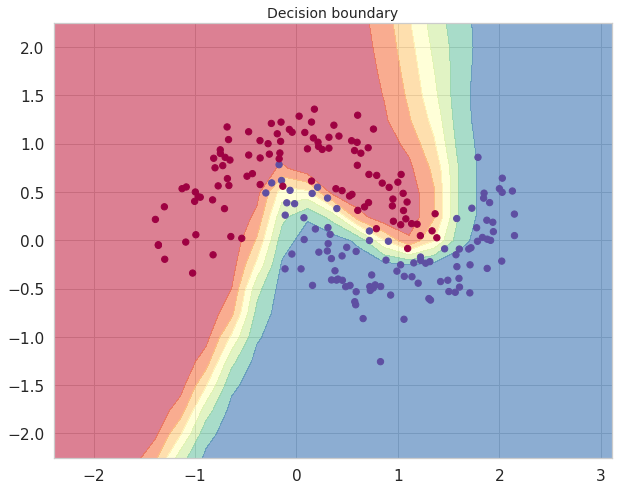

In [6]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s[1].exp().data/(s[0].exp()+s[1].exp()).data for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(10, 8))
plt.title("Decision boundary", fontsize=14)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()



## General training loop - Catalyst intro - Runner¶

Code above can be reused for almost all machine learning task. Let's take a look on experiment structure

```
for stage in stage:
    for epoch in epochs:
        for loader on loaders:
            for batch in loader:
                # do something
```

### Runner

In most cases we only need to adapt our batch handling method. And here comes the Runner.

Runner is the main part of your experiment. It runs train loop, calls callbacks (we will discusds them later) and keeps track on your model. And the only thing you need to change is _handle_batch method.


In [10]:
from tqdm.notebook import tqdm


class Runner:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        datasets,
        batch_size
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.datasets = datasets

        self.batch_size = batch_size

        self.input = {}
        self.output = {}
        self.batch_metrics = {}
        self.loader_metrcis = {}
        self.epoch_metrics = {}

    def _handle_batch(self, batch, train=True):
        """
        Stores the main logic of data aggregating.
        """
        loss = 0
        correct = 0
        for data in batch:
            output = self.model(data['features'])
            correct += output.argmax() == data['targets']
            loss += self.criterion(output, data['targets'])
        
        loss = loss / len(batch)
        accuracy = correct / len(batch)
        
        if train:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

        self.batch_metrics = {"loss": loss.item(), "accuracy": accuracy}


    def train(self, num_epochs: int = 100, verbose=False):
        for epoch in range(num_epochs):
            self.epoch_metrics = {}
            self.epoch = epoch
            for dataset_name, dataset in self.datasets.items():
                self.dataset_name = dataset_name
                self.loader_metrics = {}
                current_batch = []

                if verbose:
                    iter_ = tqdm(enumerate(dataset), total=len(dataset))
                else:
                    iter_ = enumerate(dataset)

                for idx, data in iter_:
                    last = idx == (len(dataset)-1)
                    current_batch.append(data)

                    if last or len(current_batch) == self.batch_size:
                        self._handle_batch(current_batch)
                        current_batch = []

                        for k, v in self.batch_metrics.items():
                            if k not in self.loader_metrics:
                                self.loader_metrics[k] = []
                            self.loader_metrics[k].append(v)
                
                for metric, value in self.loader_metrics.items():
                    value = np.mean(self.loader_metrics[metric])
                    self.loader_metrics[metric] = value
                    print(f"epoch {epoch}: {dataset_name} {metric} - {value}")

### Run training

In [11]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.1)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=3,
)
runner.train(10)

epoch 0: train loss - 0.465189485721676
epoch 0: train accuracy - 0.8080808080808081
epoch 0: valid loss - 0.338601334246186
epoch 0: valid accuracy - 0.8482587064676618
epoch 1: train loss - 0.3060313114449213
epoch 1: train accuracy - 0.8636363636363636
epoch 1: valid loss - 0.24582539932282788
epoch 1: valid accuracy - 0.8855721393034826
epoch 2: train loss - 0.22313729361939427
epoch 2: train accuracy - 0.888888888888889
epoch 2: valid loss - 0.19489857704254232
epoch 2: valid accuracy - 0.9054726368159204
epoch 3: train loss - 0.1869219651907495
epoch 3: train accuracy - 0.8939393939393939
epoch 3: valid loss - 0.1693819622280697
epoch 3: valid accuracy - 0.9253731343283582
epoch 4: train loss - 0.17120261182069627
epoch 4: train accuracy - 0.9191919191919192
epoch 4: valid loss - 0.1552689654454455
epoch 4: valid accuracy - 0.9353233830845771
epoch 5: train loss - 0.17019771785301044
epoch 5: train accuracy - 0.9090909090909091
epoch 5: valid loss - 0.14696465375588205
epoch 5: v

### Visualization

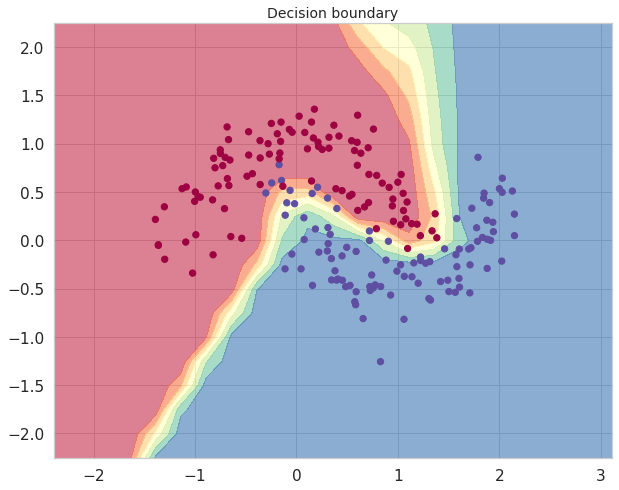

In [12]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s[1].exp().data/(s[0].exp()+s[1].exp()).data for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(10, 8))
plt.title("Decision boundary", fontsize=14)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


## General training loop - Catalyst intro - Callbacks

But could we make it even more general? Should we rewrite loss.backward or compute accuracy again and again? Do we really need it?

I don't think so, I think, we could introduce another general abstaction for typical train-loop logic. Let's introduce Callbacks!

### Callbacks

In catalyst callbacks have significant impact in everything you do.
Let's try to implement some of them.

There are a list of moments, where callbacks can be integrated. We will need only three of them.
```
on_stage_start
    on_epoch_start
        on_loader_start
            on_batch_start
------->    on_batch_end
----->  on_loader_end
--> on_epoch_end
on_stage_end
```

In [55]:
class Callback:
    def on_stage_start(self):
        pass

    def on_stage_end(self):
        pass

    def on_epoch_start(self):
        pass

    def on_epoch_end(self, runner):
        pass

    def on_loader_start(self):
        pass

    def on_loader_end(self, runner):
        pass

    def on_batch_start(self, runner):
        pass

    def on_batch_end(self, runner):
        pass


class LossCallback(Callback):
    """
    Aggregating loss value.
    """
    def __init__(self):
        self.cum_loss = 0
        self.num_batches = 0

    def on_batch_end(self, runner):
        """
        On batch end action.

        Accumulates loss and num batches.

        Args:
            output: dict with loss and other model's outputs.
        """
        self.cum_loss += runner.last_loss
        self.num_batches += 1

    def on_loader_end(self, runner):
        """
        On loader end action.

        Args:
            epoch_metrics: dict with epoch metrics

        Returns:
            loss over the loader.
        """
        runner.epoch_metrics["loss"] = self.cum_loss.item() / self.num_batches
        self.cum_loss = 0
        self.num_batches = 0


class AccuracyCallback(Callback):
    """
    Aggregating accuracy value.
    """
    def __init__(self):
        self.correct = 0
        self.total = 0

    def on_batch_end(self, runner):
        """
        On batch end action

        Accumulates number of correct predictions.

        Args:
            output: dict with number of the correct predictions
        """
        for data, outp in zip(runner.input, runner.output):
            self.correct += outp.argmax() == data["targets"]
            self.total += 1

    def on_loader_end(self, runner):
        """
        On loader end action.

        Args:
            epoch_metrics: dict with epoch metrics

        Returns:
            accuracy value over the loader.
        """
        runner.epoch_metrics["accuracy"] = self.correct / self.total
        self.correct = 0
        self.total = 0


class LoggerCallback(Callback):
    """
    Log metrics to output.
    """
    def __init__(self, log_period):
        self.log_period = log_period

    def on_epoch_end(self, runner):
        """
        On epoch end action.

        Prints all epoch metrics if log_period is suitable.

        Args:
            epoch_metrics: dict with epoch metrics
            epoch: current epoch
        """
        if runner.epoch % self.log_period == 0:
            log_string = f"Epoch: {runner.epoch}\n"
            for metric, value in runner.epoch_metrics.items():
                log_string += f"{metric}: {value}\n"
            print(log_string)


class OptimizerCallback(Callback):
    def on_batch_start(self, runner):
        if runner.dataset_name == "train":
            runner.optimizer.zero_grad()

    def on_batch_end(self, runner):
        loss = 0
        for data, outp in zip(runner.input, runner.output):
            current_loss = runner.criterion(outp, data["targets"])
            loss += current_loss
        
        loss = loss / len(runner.input)
        loss.backward()
        runner.last_loss = loss
        if runner.dataset_name == "train":
            runner.optimizer.step()

In [56]:
from tqdm.notebook import tqdm


class Runner:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        datasets,
        batch_size,
        callbacks,
    ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.datasets = datasets

        self.batch_size = batch_size
        self.callbacks = callbacks
        
        self.last_loss = None
        self.input = {}
        self.output = {}
        self.batch_metrics = {}
        self.loader_metrcis = {}
        self.epoch_metrics = {}

    def _handle_batch(self, batch):
        """
        Stores the main logic of data aggregating.
        """
        output = []
        for data in batch:
            output.append(self.model(data['features']))
        self.input = batch
        self.output = output


    def train(self, num_epochs: int = 100, verbose=False):
        for epoch in range(num_epochs):
            self.epoch_metrics = {}
            self.epoch = epoch
            for dataset_name, dataset in self.datasets.items():
                self.dataset_name = dataset_name
                self.loader_metrics = {}
                current_batch = []

                if verbose:
                    iter_ = tqdm(enumerate(dataset), total=len(dataset))
                else:
                    iter_ = enumerate(dataset)

                for idx, data in iter_:
                    last = idx == (len(dataset)-1)
                    current_batch.append(data)

                    if last or len(current_batch) == self.batch_size:
                        for clb in self.callbacks.values():
                            clb.on_batch_start(self)

                        self._handle_batch(current_batch)
                        current_batch = []

                        for clb in self.callbacks.values():
                            clb.on_batch_end(self)

                for clb in self.callbacks.values():
                    clb.on_loader_end(self)
            for clb in self.callbacks.values():
                    clb.on_epoch_end(self)

### Run training

In [57]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.1)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=3,
    callbacks={
        "optimizer": OptimizerCallback(),
        "accuracy": AccuracyCallback(),
        "loss": LossCallback(),
        "logger": LoggerCallback(log_period=1),
    }
)
runner.train(50)

Epoch: 0
accuracy: 0.83
loss: 0.3604298933123094

Epoch: 1
accuracy: 0.845
loss: 0.33404181726191395

Epoch: 2
accuracy: 0.845
loss: 0.3200984011018237

Epoch: 3
accuracy: 0.86
loss: 0.3015566299780362

Epoch: 4
accuracy: 0.865
loss: 0.2813626656302437

Epoch: 5
accuracy: 0.87
loss: 0.2615696084233826

Epoch: 6
accuracy: 0.88
loss: 0.24774175518653305

Epoch: 7
accuracy: 0.885
loss: 0.23815087270626528

Epoch: 8
accuracy: 0.895
loss: 0.22879289671425684

Epoch: 9
accuracy: 0.905
loss: 0.21262076401442342

Epoch: 10
accuracy: 0.91
loss: 0.20723555511645247

Epoch: 11
accuracy: 0.92
loss: 0.19706224878702533

Epoch: 12
accuracy: 0.925
loss: 0.19081668067600294

Epoch: 13
accuracy: 0.925
loss: 0.18577880537167976

Epoch: 14
accuracy: 0.93
loss: 0.1824800961708335

Epoch: 15
accuracy: 0.93
loss: 0.18206081838114455

Epoch: 16
accuracy: 0.925
loss: 0.18051129706434293

Epoch: 17
accuracy: 0.93
loss: 0.17446204389653427

Epoch: 18
accuracy: 0.93
loss: 0.16862226119218063

Epoch: 19
accuracy:

### Visualization

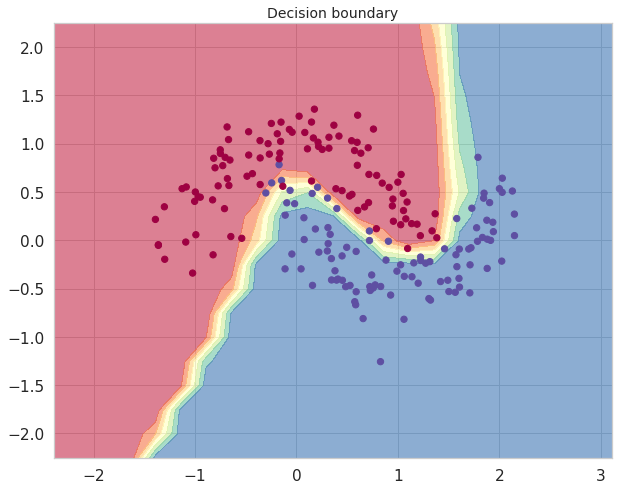

In [58]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s[1].exp().data/(s[0].exp()+s[1].exp()).data for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(10, 8))
plt.title("Decision boundary", fontsize=14)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


## MNIST

Try to train model on MNIST task!

In [59]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [67]:
y_train[3]

1

In [68]:
class MNISTDataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return {"features": self.x[idx].flatten(), "targets": self.y[idx]}

    def __len__(self):
        return len(self.y)

# Python is slow, that's why we use only small group of object
datasets = {
    "train": MNISTDataset(X_train[:2000], y_train[:2000]),
    "valid": MNISTDataset(X_val[:200], y_val[:200])
} 

In [75]:
class MnistModel(Module):
    def __init__(self, input_size=28*28):
        self.layers = [
            Linear(input_size, 30),
        ]
        self.final = Linear(30, 10)
        self.relu = ReLU()

    def forward(self, inp):
        inp = Tensor(inp)
        for layer in self.layers:
            inp = layer(inp)
            inp = self.relu(inp)
        inp = self.final(inp)
        return inp

    def parameters(self):
        result = []
        for layer in self.layers:
            result += [*layer.parameters()]
        result += [*self.final.parameters()]
        return result

In [ ]:
criterion = CrossEntropyLoss()
model = MnistModel()
optimizer = SGD(model.parameters(), lr=0.1)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=16,
    callbacks={
        "optimizer": OptimizerCallback(),
        "accuracy": AccuracyCallback(),
        "loss": LossCallback(),
        "logger": LoggerCallback(log_period=1),
    }
)
runner.train(5, verbose=True)